In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, f1_score  # Added f1_score import
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# 🔄 Chargement des données
df = pd.read_csv("kiali_kpi_metrics.csv")

# 🧽 Nettoyage de time_window
df['time_window'] = df['time_window'].astype(str).str.strip()
df = df[df['time_window'] == "15S"].copy()

if df.empty:
    raise ValueError("🚨 Aucun enregistrement avec time_window == '15s'. Vérifiez le fichier CSV.")

# ✅ Nettoyage des colonnes numériques
df['error_rate'] = pd.to_numeric(df['error_rate'], errors='coerce').fillna(0.0)

# 🏷️ Attribution du statut
def assign_status(er):
    if er < 0.01:
        return 0
    elif er < 0.1:
        return 1
    else:
        return 2

def assign_status(er):
    if er < 0.15:
        return 0
    
    else:
        return 1



df['status'] = df['error_rate'].apply(assign_status)
df.drop(df[df['istio_request_bytes'] == 0.0].index, inplace = True)
df.drop(df[df['new_request'] < 0.0].index, inplace = True)
df = df.dropna(subset=["request_rate"])
df.to_csv("data2.csv", index=False)







class MicroserviceDataset:
    def __init__(self, df, node_map, features, target):
        self.df = df
        self.node_map = node_map
        self.features = features
        self.target = target
        
    def __len__(self):
        return 1  # We'll treat the whole dataset as one graph
    
    def __getitem__(self, idx):
        edge_index = []
        edge_attr = []
        edge_labels = []
        
        # Create edges with features and labels
        for _, row in self.df.iterrows():
            src = self.node_map[row['source_workload']]
            tgt = self.node_map[row['destination_workload']]
            edge_index.append([src, tgt])
            edge_attr.append(row[self.features].values)
            edge_labels.append(row[self.target])
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        edge_labels = torch.tensor(edge_labels, dtype=torch.long)
        
        # Create node features (using random features since we don't have node features)
        num_nodes = len(self.node_map)
        x = torch.randn((num_nodes, 16))  # 16-dimensional random features
        
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=edge_labels)

class EdgePredictorGNN(nn.Module):
    def __init__(self, node_features, edge_features, hidden_dim, num_classes):
        super().__init__()
        self.conv1 = GCNConv(node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.edge_predictor = nn.Sequential(
            nn.Linear(2 * hidden_dim + edge_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, data):
        # Node embeddings
        x = self.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        
        # Edge prediction
        src, dst = data.edge_index
        h_src = x[src]
        h_dst = x[dst]
        
        # Combine node embeddings and edge features
        edge_emb = torch.cat([h_src, h_dst, data.edge_attr], dim=1)
        return self.edge_predictor(edge_emb)

def train():
    # Load and preprocess data
    df = pd.read_csv('data2.csv')
    

    df['timestamp'] = pd.to_datetime(df['timestamp']).astype(int) / 10**9  # Convert to seconds


    # Prepare features and target
    features = ['throughput', 'duration_milliseconds', 'request_rate','istio_request_bytes','average_latency','istio_request_bytes','new_request','timestamp']  # Excluding error_rate
    target = 'status'
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    #df[features] = StandardScaler().fit_transform(df[features])
    
    # Create node mapping
    all_nodes = sorted(list(set(df['source_workload'].unique()).union(set(df['destination_workload'].unique()))))
    node_map = {node: i for i, node in enumerate(all_nodes)}
    
    # Create dataset
    dataset = MicroserviceDataset(df, node_map, features, target)
    
    # Since we have one graph, we'll use a single DataLoader with batch_size=1
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Initialize model
    model = EdgePredictorGNN(
        node_features=16,  # Matches our random node features
        edge_features=len(features),
        hidden_dim=64,
        num_classes=2  # healthy, degraded, error
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    for epoch in range(1, 101):
        model.train()
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Print training stats
        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d} | Loss: {total_loss/len(loader):.4f}')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        data = dataset[0].to(device)
        out = model(data)
        pred = out.argmax(dim=1).cpu().numpy()
        truth = data.y.cpu().numpy()
        
        print("\nClassification Report:")
        print(classification_report(truth, pred, target_names=['healthy', 'degraded']))
        print("Macro F1-score:", f1_score(truth, pred, average='macro'))

if __name__ == "__main__":
    train()

C:\Users\marti\AppData\Local\Temp\ipykernel_28144\1763659225.py:85: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  edge_attr = torch.tensor(edge_attr, dtype=torch.float)


Epoch 010 | Loss: 0.8456
Epoch 020 | Loss: 0.7659
Epoch 030 | Loss: 0.6720
Epoch 040 | Loss: 0.3365
Epoch 050 | Loss: 0.7221
Epoch 060 | Loss: 0.5454
Epoch 070 | Loss: 0.7334
Epoch 080 | Loss: 0.9527
Epoch 090 | Loss: 0.3042
Epoch 100 | Loss: 0.1452

Classification Report:
              precision    recall  f1-score   support

     healthy       0.92      1.00      0.96       357
    degraded       0.00      0.00      0.00        31

    accuracy                           0.92       388
   macro avg       0.46      0.50      0.48       388
weighted avg       0.85      0.92      0.88       388

Macro F1-score: 0.4791946308724832


c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 1 | Loss: 1.1142
Epoch 2 | Loss: 1.0303
Epoch 3 | Loss: 0.9176
Epoch 4 | Loss: 0.8178
Epoch 5 | Loss: 0.7378
Epoch 6 | Loss: 0.7224
Epoch 7 | Loss: 0.7221
Epoch 8 | Loss: 0.7077
Epoch 9 | Loss: 0.7270
Epoch 10 | Loss: 0.6740
Epoch 11 | Loss: 0.6735
Epoch 12 | Loss: 0.6391
Epoch 13 | Loss: 0.6165
Epoch 14 | Loss: 0.6067
Epoch 15 | Loss: 0.5945
Epoch 16 | Loss: 0.5808
Epoch 17 | Loss: 0.5707
Epoch 18 | Loss: 0.5553
Epoch 19 | Loss: 0.5358
Epoch 20 | Loss: 0.5249
Epoch 21 | Loss: 0.5094
Epoch 22 | Loss: 0.5066
Epoch 23 | Loss: 0.5156
Epoch 24 | Loss: 0.5145
Epoch 25 | Loss: 0.5041
Epoch 26 | Loss: 0.5084
Epoch 27 | Loss: 0.4858
Epoch 28 | Loss: 0.4872
Epoch 29 | Loss: 0.4876
Epoch 30 | Loss: 0.4910
Epoch 31 | Loss: 0.4874
Epoch 32 | Loss: 0.4892
Epoch 33 | Loss: 0.4781
Epoch 34 | Loss: 0.4846
Epoch 35 | Loss: 0.4791
Epoch 36 | Loss: 0.4806
Epoch 37 | Loss: 0.4765
Epoch 38 | Loss: 0.4792
Epoch 39 | Loss: 0.4740
Epoch 40 | Loss: 0.4763
Epoch 41 | Loss: 0.4726
Epoch 42 | Loss: 0.4724
E

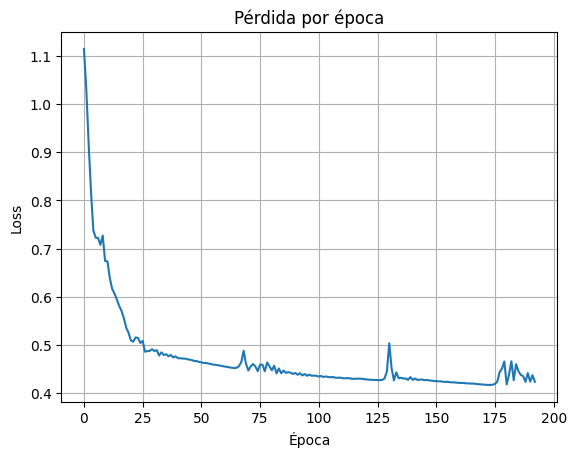

\nClassification Report:
              precision    recall  f1-score   support

   saludable       1.00      0.75      0.85       326
   degradado       0.25      0.87      0.39        31
 fallo grave       0.70      0.84      0.76        31

    accuracy                           0.77       388
   macro avg       0.65      0.82      0.67       388
weighted avg       0.91      0.77      0.81       388

Macro F1-score: 0.671169149010033


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from collections import Counter

# 📥 Cargar datos
df = pd.read_csv("kiali_kpi_metrics.csv")
df['time_window'] = df['time_window'].astype(str).str.strip()
df = df[df['time_window'] == "15S"].copy()
df['error_rate'] = pd.to_numeric(df['error_rate'], errors='coerce').fillna(0.0)
df = df[df['istio_request_bytes'] != 0.0]
df = df[df['new_request'] >= 0.0]
df = df.dropna(subset=["request_rate"])
df['timestamp'] = pd.to_datetime(df['timestamp']).astype(int) / 10**9

# 🏷 Etiquetas multiclase
def assign_status(er):
    if er < 0.01:
        return 0
    elif er < 0.15:
        return 1
    else:
        return 2
df['status'] = df['error_rate'].apply(assign_status)

# 🎛 Normalización
features = ['throughput', 'duration_milliseconds', 'request_rate',
            'istio_request_bytes', 'average_latency', 'new_request', 'timestamp']
df[features] = MinMaxScaler().fit_transform(df[features])
target = 'status'

# 🔀 Mapeo de nodos y estadísticas como embeddings
all_nodes = sorted(set(df['source_workload']).union(df['destination_workload']))
node_map = {node: i for i, node in enumerate(all_nodes)}

# Crear embeddings reales de nodos
node_stats = df.groupby('source_workload')[features].mean()
x_features = np.zeros((len(node_map), len(features)))
for node, idx in node_map.items():
    if node in node_stats.index:
        x_features[idx] = node_stats.loc[node].values
    else:
        x_features[idx] = np.random.rand(len(features))  # fallback aleatorio

x_tensor = torch.tensor(x_features, dtype=torch.float)

# 🔁 Dataset
class MicroserviceDataset:
    def __init__(self, df, node_map, features, target):
        self.df = df
        self.node_map = node_map
        self.features = features
        self.target = target

    def __len__(self): return 1

    def __getitem__(self, idx):
        edge_index, edge_attr, edge_labels = [], [], []

        for _, row in self.df.iterrows():
            src = self.node_map[row['source_workload']]
            tgt = self.node_map[row['destination_workload']]
            edge_index.append([src, tgt])
            edge_attr.append(row[self.features].values)
            edge_labels.append(row[self.target])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        edge_labels = torch.tensor(edge_labels, dtype=torch.long)

        return Data(x=x_tensor, edge_index=edge_index, edge_attr=edge_attr, y=edge_labels)

# 🧠 Modelo
class EdgePredictorGNN(nn.Module):
    def __init__(self, node_features, edge_features, hidden_dim, num_classes):
        super().__init__()
        self.conv1 = GCNConv(node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.edge_predictor = nn.Sequential(
            nn.Linear(2 * hidden_dim + edge_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        src, dst = data.edge_index
        h_src = x[src]
        h_dst = x[dst]
        edge_emb = torch.cat([h_src, h_dst, data.edge_attr], dim=1)
        return self.edge_predictor(edge_emb)

# ⚙️ Configuración y entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = MicroserviceDataset(df, node_map, features, target)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
model = EdgePredictorGNN(7, 7, 64, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 🧮 Pesos de clases
class_counts = Counter(df['status'])
total = sum(class_counts.values())
weights = [total / class_counts[i] for i in range(3)]
weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# 🚂 Entrenamiento + logging
losses = []
best_loss = float("inf")
patience = 20
wait = 0

for epoch in range(1, 301):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
    print(f"Epoch {epoch} | Loss: {total_loss:.4f}")
    
    # Early stopping
    if total_loss < best_loss:
        best_loss = total_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹ Early stopping triggered")
            break

# 📈 Gráfico de pérdida
plt.plot(losses)
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 📊 Evaluación
model.eval()
with torch.no_grad():
    data = dataset[0].to(device)
    out = model(data)
    pred = out.argmax(dim=1).cpu().numpy()
    truth = data.y.cpu().numpy()
    print("\\nClassification Report:")
    print(classification_report(truth, pred, target_names=['saludable', 'degradado', 'fallo grave']))
    print("Macro F1-score:", f1_score(truth, pred, average='macro'))


In [26]:
!pip install --upgrade --force-reinstall dgl


  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ----- ---------------------------------- 0.8/5.3 MB 4.8 MB/s eta 0:00:01
   ------------- -------------------------- 1.8/5.3 MB 4.4 MB/s eta 0:00:01
   ------------------- -------------------- 2.6/5.3 MB 4.3 MB/s eta 0:00:01
   ------------------------- -------------- 3.4/5.3 MB 4.3 MB/s eta 0:00:01
   ------------------------------- -------- 4.2/5.3 MB 4.2 MB/s eta 0:00:01
   ------------------------------------- -- 5.0/5.3 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 5.3/5.3 MB 4.1 MB/s eta 0:00:00
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.9 MB 2.8 MB/s eta 0:00:05


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch-geometric-temporal 0.54.0 requires pandas<=1.3.5, but you have pandas 2.3.0 which is incompatible.
torchaudio 2.2.0+cu118 requires torch==2.2.0+cu118, but you have torch 2.7.1 which is incompatible.
torchvision 0.17.0+cu118 requires torch==2.2.0+cu118, but you have torch 2.7.1 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\marti\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [27]:

!pip install torch



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\marti\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [18]:
pip uninstall dgl -y

Note: you may need to restart the kernel to use updated packages.
Found existing installation: dgl 2.2.1
Uninstalling dgl-2.2.1:
  Successfully uninstalled dgl-2.2.1


ERROR: Exception:
Traceback (most recent call last):
  File "c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_internal\cli\base_command.py", line 180, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_internal\commands\uninstall.py", line 110, in run
    uninstall_pathset.commit()
  File "c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_internal\req\req_uninstall.py", line 432, in commit
    self._moved_paths.commit()
  File "c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_internal\req\req_uninstall.py", line 278, in commit
    save_dir.cleanup()
  File "c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_internal\utils\temp_dir.py", line 173, in cleanup
    rmtree(self._path)
  File "c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\pi

In [30]:
import pandas as pd
import torch
# DGL is already installed in a previous cell using `!pip install --upgrade --force-reinstall dgl`
import dgl
import torch.nn as nn
import torch.nn.functional as F

from dgl.nn import GraphConv
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


ModuleNotFoundError: No module named 'dgl'

In [32]:
# Cargar datasets
nodes_df = pd.read_csv("fused_nodes.csv")
edges_df = pd.read_csv("fused_edges.csv")

# Mapear nodos a índices
node_ids = {name: idx for idx, name in enumerate(nodes_df['id'].unique())}
nodes_df['idx'] = nodes_df['id'].map(node_ids)

# Codificar la clase
le = LabelEncoder()
nodes_df['label'] = le.fit_transform(nodes_df['Abnormality class'].astype(str))

# Crear features
feature_cols = ['success_rate', 'error_rate', 'request_rate', 'throughput', 'pagerank', 'motif_1', 'motif_2', 'motif_3']
feature_cols = [col for col in feature_cols if col in nodes_df.columns]
X = nodes_df[feature_cols].fillna(0)
X = torch.tensor(StandardScaler().fit_transform(X), dtype=torch.float32)
y = torch.tensor(nodes_df['label'].values, dtype=torch.long)

# Crear aristas
edges_df = edges_df.dropna(subset=["src", "dst"])
edges_df = edges_df[edges_df["src"].isin(node_ids) & edges_df["dst"].isin(node_ids)]
src = edges_df["src"].map(node_ids).tolist()
dst = edges_df["dst"].map(node_ids).tolist()

# Crear grafo
g = dgl.graph((src, dst), num_nodes=len(nodes_df))
g.ndata['feat'] = X
g.ndata['label'] = y


class GNNModel(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super().__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
        self.classify = nn.Linear(h_feats, num_classes)

    def forward(self, g, x):
        h = F.relu(self.conv1(g, x))
        h = F.dropout(h, 0.3, training=self.training)
        h = self.conv2(g, h)
        return self.classify(h)


# Split en train/test
idx = list(range(len(nodes_df)))
train_idx, test_idx = train_test_split(idx, stratify=y.numpy(), test_size=0.3, random_state=42)

train_mask = torch.zeros(len(nodes_df), dtype=torch.bool)
test_mask = torch.zeros(len(nodes_df), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

# Instanciar modelo
model = GNNModel(in_feats=X.shape[1], h_feats=64, num_classes=len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# Entrenar
for epoch in range(100):
    model.train()
    out = model(g, g.ndata['feat'])
    loss = loss_fn(out[train_mask], y[train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss {loss.item():.4f}")


model.eval()
with torch.no_grad():
    pred = model(g, g.ndata['feat'])[test_mask].argmax(dim=1)
    print("Accuracy:", accuracy_score(y[test_mask].numpy(), pred.numpy()))
    print(classification_report(y[test_mask].numpy(), pred.numpy(), target_names=le.classes_))


FileNotFoundError: [Errno 2] No such file or directory: 'fused_nodes.csv'